In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
#%pylab
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as patches
import scipy
from scipy import interpolate
import pandas as pd
import itertools
from root_numpy import root2array, root2rec, tree2rec, array2root
import ROOT
#import larocv.data
from ROOT import geo2d
geo2d.load_pyutil
from ROOT.cv import Point_ as Vector
DTYPE='float'
pdraw = geo2d.PyDraw()
from ROOT import larocv

In [2]:
# configuration parameters for image generation
VERTEX_XMIN  = 50     # lower bound of x-range for random vtx
VERTEX_XMAX  = 50.01  # upper bound of x-range for random vtx
VERTEX_YMIN  = 50     # lower bound of y-range for random vtx
VERTEX_YMAX  = 50.01  # upper bound of y-range for random vtx
IMAGE_HEIGHT = 100    # image height
IMAGE_WIDTH  = 100    # image width
NOISE_LEVEL  = 0.0    # white noise level
PI_VALUE     = 10     # pixel value

NTRACKS          = [2,3]  # number of possible tracks to generate
TRACK_LENGTH_MAX = 100    # max track length
TRACK_LENGTH_MIN = 10     # min track length
# configuration parameter for algorithm testing
PI_THRESHOLD=0.5
RADIUS = 6

# Algorithm instance
alg = larocv.VertexParticleCluster()
alg._pi_threshold = PI_THRESHOLD
alg.set_verbosity(0)
larocv.logger.get_shared().set(0)

In [3]:
def gen_image():
    # Image size
    width,height=(IMAGE_WIDTH, IMAGE_HEIGHT)
    # Noise pixel fraction
    noise=NOISE_LEVEL
    # Vertex region
    vtx_xmin,vtx_xmax = (VERTEX_XMIN,VERTEX_XMAX)
    vtx_ymin,vtx_ymax = (VERTEX_YMIN,VERTEX_YMAX)
    # Track counts
    ntracks=NTRACKS
    # Track lenth
    tracklen_min,tracklen_max=(TRACK_LENGTH_MIN,TRACK_LENGTH_MAX)

    # Make background image
    data = np.zeros(width*height,DTYPE)
    data[int(len(data)*(1.-noise)):] = 1
    random.shuffle(data)
    data=data.reshape(height,width)

    #fig,ax = plt.subplots(figsize=(12,8))
    #im = plt.imshow(data, cmap='jet')
    #plt.colorbar(im, orientation='horizontal')
    #plt.show()

    # Generate vertex
    vtx   = Vector(DTYPE)()
    vtx.x = random.random() * (vtx_xmax - vtx_xmin) + vtx_xmin
    vtx.y = random.random() * (vtx_ymax - vtx_ymin) + vtx_ymin

    # Generate tracks
    random.shuffle(ntracks)
    ntrack = ntracks[0]

    # Generate angle
    segments=[]
    for idx in xrange(ntrack):
        pt1 = vtx
        pt2 = Vector(DTYPE)()
        angle = random.random() * 360
    
        line = geo2d.Line(DTYPE)(vtx,angle)

        pt2.x,pt2.y = (pt1.x,pt1.y)
        length = float(random.random() * (tracklen_max - tracklen_min) + tracklen_min) 
        ctr = 0
        while length > ctr:
            pt2.x += line.dir.x 
            pt2.y += line.dir.y
            if pt2.x < 0 or pt2.x > width or pt2.y < 0 or pt2.y > height:
                break
            x = int(pt2.x)
            y = int(pt2.y)
            data[y][x] += PI_VALUE
            ctr+=1

        segments.append(geo2d.LineSegment(DTYPE)(pt1,pt2))

    fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
    im = plt.imshow(data, cmap='jet')
    #plt.colorbar(im, orientation='horizontal')
    plt.show()
    return (vtx,segments,data)



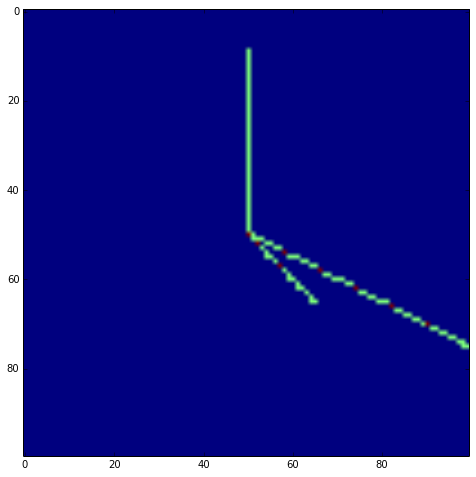

Generated vtx @ (x,y) = ( 50.0013694763 , 50.0049514771 )
3 crossings...
xs 0 @ 54.2011222839 , 54.2900505066
xs 1 @ 55.3425521851 , 52.738407135
xs 2 @ 50.0116004944 , 44.0049591064



In [6]:
vtx,lines,data = gen_image()
# figure out xs point
circle = geo2d.Circle(DTYPE)()
circle.center = vtx
circle.radius = RADIUS

# define a larocv::CircleVertex
vtx2d = larocv.data.CircleVertex()
vtx2d.center = vtx
vtx2d.radius = RADIUS
print 'Generated vtx @ (x,y) = (',vtx.x,',',vtx.y,')'
print len(lines),'crossings...'
for idx in xrange(len(lines)):
    line = lines[idx]
    pts = geo2d.IntersectionPoint(circle,line)
    for pt_idx in xrange(pts.size()):
        pt = pts[pt_idx]
        vtx2d.xs_v.push_back(larocv.data.PointPCA())
        vtx2d.xs_v.back().pt = pt
        print 'xs',idx,'@',vtx2d.xs_v.back().pt.x,',',vtx2d.xs_v.back().pt.y
print
mat = pdraw.mat(data.astype(np.float32))


Found 3 clusters


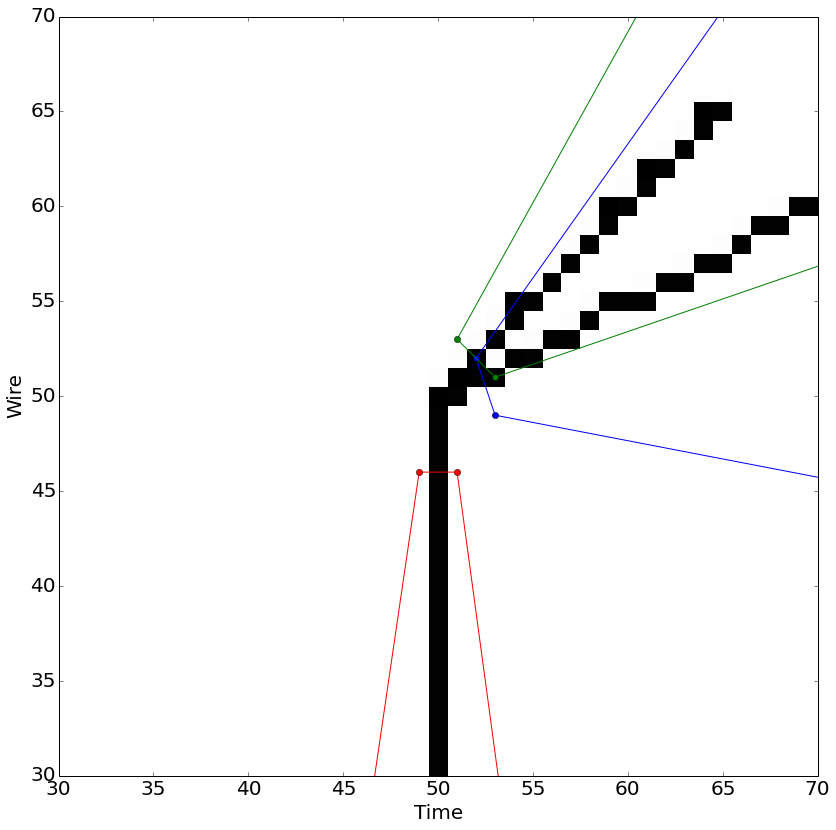

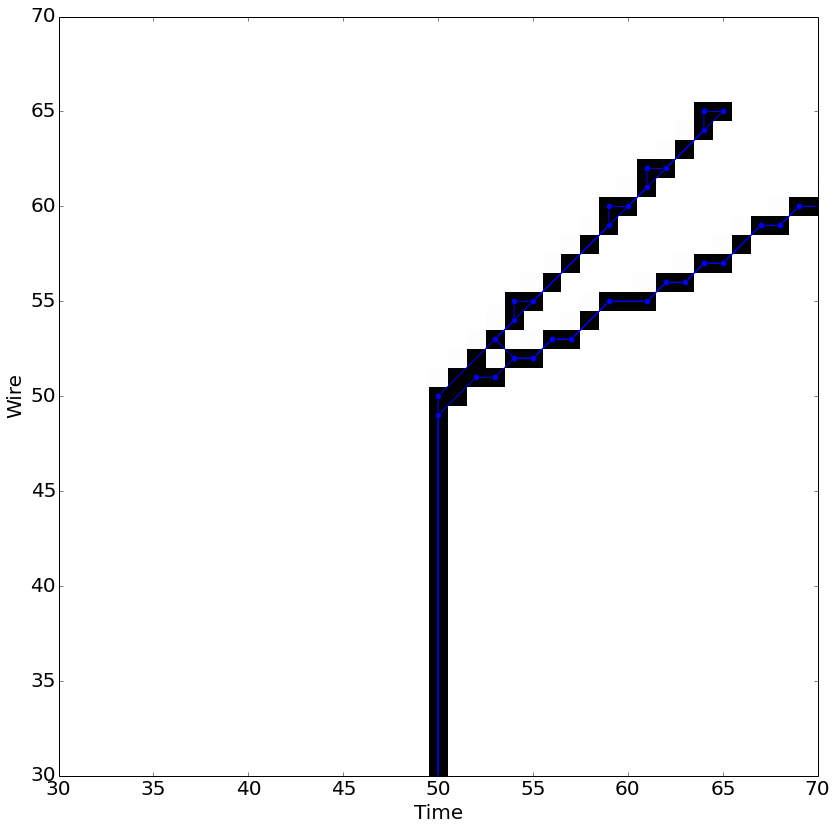

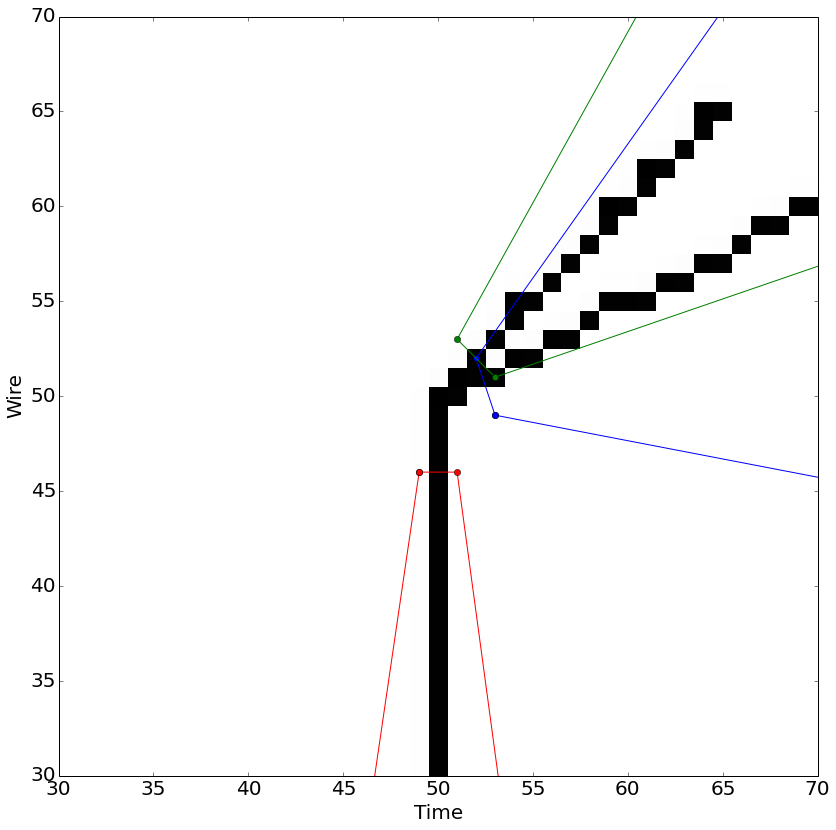

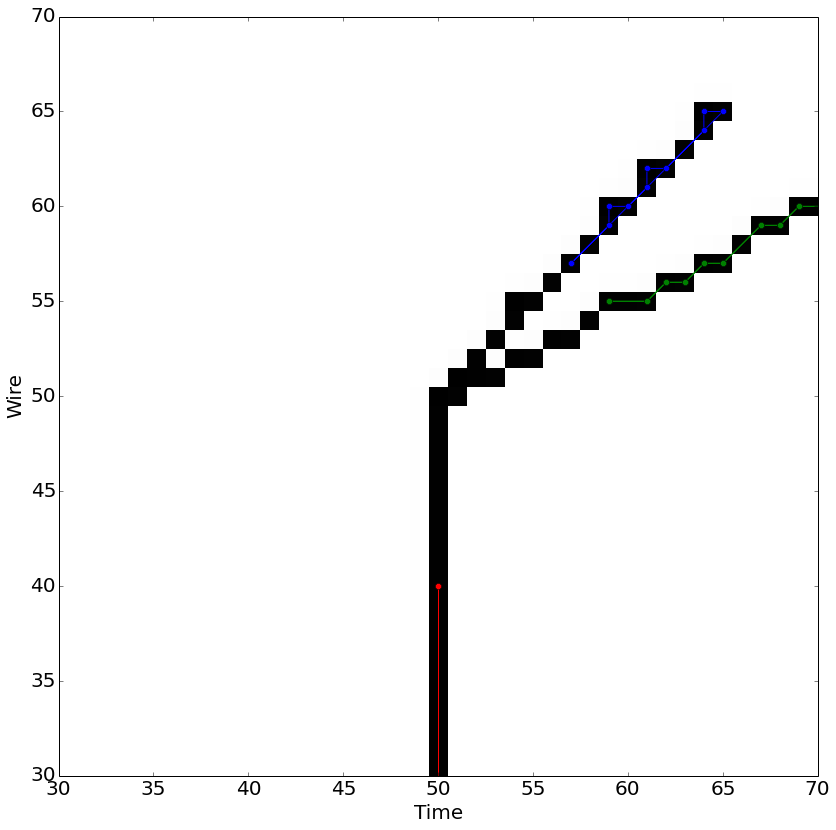

In [8]:
res=alg.CreateParticleCluster(mat,vtx2d)
print 'Found',res.size(),'clusters'

super_cluster_v = alg.SuperClusters()
seed_cluster_v  = alg.SeedClusters()
child_cluster_v = alg.ChildClusters()

for cluster_v in [res,super_cluster_v,seed_cluster_v,child_cluster_v]:

    shape_img=np.where(data>0.5,1.0,0.0).astype(np.uint8)
    fig,ax=plt.subplots(figsize=(12,12),facecolor='w')
    plt.imshow(shape_img,cmap='Greys',interpolation='none')
    for ctor in cluster_v:
        pts=[[pt.x,pt.y] for pt in ctor]
        if len(pts)<1: continue
        pts.append(pts[0])
        pts = np.array(pts)
        plt.plot(pts[:,0],pts[:,1],'-o')

    plt.xlabel('Time',fontsize=20)
    plt.ylabel('Wire',fontsize=20)
    plt.tick_params(labelsize=20)
    #ax.set_aspect(0.8)
    plt.tight_layout()
    plt.xlim(30,70)
    plt.ylim(30,70)
    plt.show()

